[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)


# 支持消息摘要与外部数据库记忆的聊天机器人

## 回顾

我们已经介绍了如何自定义图状态模式和归约器。

还展示了若干在图状态中修剪或过滤消息的技巧。

我们已将这些概念应用于一个具备记忆功能的聊天机器人，该机器人能够持续生成对话摘要。

## 目标

但如果我们需要聊天机器人具备永久性记忆呢？

现在，我们将引入一些支持外部数据库的更高级检查点机制。

这里将演示如何使用[Sqlite作为检查点](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)，当然也支持其他检查点方案，例如[Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/)！


In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Sqlite

这里一个不错的起点是[SqliteSaver检查点工具](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)。

Sqlite是一款[小巧、快速、广受欢迎](https://x.com/karpathy/status/1819490455664685297)的SQL数据库。

如果我们传入`":memory:"`参数，它会创建一个内存中的Sqlite数据库。


In [ ]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

但是，如果我们提供一个数据库路径，它就会为我们创建一个数据库！


In [2]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [3]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

让我们重新定义我们的聊天机器人。


In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

现在，我们只需使用 SQLite 检查点程序重新编译即可。


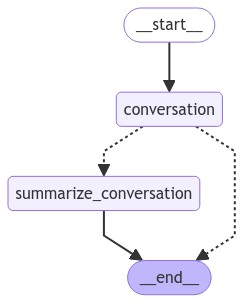

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

现在，我们可以多次调用该图。


In [6]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_18873/2173919996.py:55: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


================================== Ai Message ==================================

Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!
================================== Ai Message ==================================

Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?
================================== Ai Message ==================================

That's awesome, Lance! The San Francisco 49ers have a rich history and a passionate fan base. Is there a specific aspect of the team you'd like to discuss? For example, we could talk about:

- Their legendary players like Joe Montana and Jerry Rice
- Memorable games and Super Bowl victories
- The current roster and season prospects
- Rivalries, like the one with the Seattle Seahawks
- Levi's Stadium and

让我们确认状态已保存在本地。


In [7]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

### 持久化状态

使用 Sqlite 这类数据库意味着状态将被持久保存！

例如，我们可以重启 notebook 内核后，仍能从磁盘上的 Sqlite 数据库加载数据。


In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

## LangGraph Studio

**⚠️ 免责声明**

自这些视频录制以来，我们已对 Studio 进行了更新，现在可以在本地运行并在浏览器中打开。这是目前运行 Studio 的首选方式（而非视频中演示的桌面应用程序）。关于本地开发服务器的文档请参见[此处](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)，运行说明请参考[此指南](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录下执行以下终端命令：

```
langgraph dev
```

您将看到如下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio 界面: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API 文档: http://127.0.0.1:2024/docs
```

打开浏览器并访问 Studio 界面：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。


```markdown
# Getting Started with React

## Prerequisites

Before you start working with React, make sure you have the following installed:

- Node.js (version 14 or later)
- npm (version 6 or later) or yarn
- A code editor (VS Code recommended)

## Creating a New React App

The easiest way to create a new React application is by using Create React App:

```bash
npx create-react-app my-app
cd my-app
npm start
```

This will:
1. Set up a new React project in the `my-app` directory
2. Install all required dependencies
3. Start the development server

## Key Concepts

### Components

React applications are built using components. A component is a reusable piece of UI that can contain:

- HTML-like JSX syntax
- State (data that can change)
- Props (data passed from parent components)

### JSX

JSX is a syntax extension for JavaScript that looks similar to HTML:

```jsx
const element = <h1>Hello, world!</h1>;
```

### State and Props

- **State**: Internal data managed by the component
- **Props**: External data passed to the component

## Next Steps

After mastering these basics, you can explore:

- React Hooks
- Context API
- React Router
- State management libraries (Redux, MobX)
```

```markdown
# React 入门指南

## 环境准备

开始使用 React 前，请确保已安装以下工具：

- Node.js（版本 14 或更高）
- npm（版本 6 或更高）或 yarn
- 代码编辑器（推荐 VS Code）

## 创建新 React 应用

使用 Create React App 是创建新 React 应用的最简单方式：

```bash
npx create-react-app my-app
cd my-app
npm start
```

该命令将：
1. 在 `my-app` 目录中创建新的 React 项目
2. 安装所有必需的依赖项
3. 启动开发服务器

## 核心概念

### 组件

React 应用由组件构成。组件是可复用的 UI 单元，可包含：

- 类 HTML 的 JSX 语法
- 状态（可变化的数据）
- 属性（从父组件传递的数据）

### JSX

JSX 是 JavaScript 的语法扩展，外观类似 HTML：

```jsx
const element = <h1>Hello, world!</h1>;
```

### 状态与属性

- **状态**：组件内部管理的数据
- **属性**：传递给组件的外部数据

## 后续学习

掌握这些基础知识后，可继续探索：

- React Hooks
- Context API
- React Router
- 状态管理库（Redux、MobX）
```
